In [1]:
! pip3 install scikit-learn

In [2]:
import os, glob, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")


In [3]:
fn='final_combine_data.csv'
outfd=pd.read_csv(fn)
print(outfd.head())
outfd['date'] = pd.to_datetime(outfd['datetime'])


     datetime  Daily_DS_cm  13D_smooth_DS_cm  Daily_sm_set1  Daily_sm_set5  \
0  2023-06-08       0.2973            0.3803          11.90          29.88   
1  2023-06-09       0.2860            0.3655          12.62          29.14   
2  2023-06-10       0.2772            0.3513          12.97          28.36   
3  2023-06-11       0.2718            0.3383          12.79          27.40   
4  2023-06-12       0.2656            0.3262          12.37          26.62   

   13D_sm_set1  13D_sm_set5  301_gw_elev  302_gw_elev  303_gw_elev  \
0      11.4392      33.5392    1707.6860    1707.4302    1706.9940   
1      11.4831      32.9538    1707.6733    1707.4177    1706.9840   
2      11.5523      32.3454    1707.6692    1707.4083    1706.9754   
3      11.6131      31.6908    1707.6529    1707.3990    1706.9688   
4      11.6569      31.0038    1707.6421    1707.3958    1706.9673   

   13D_smooth_GW301_m  13D_smooth_GW302_m  13D_smooth_GW303_m  Daily_precip_mm  
0           1707.7723        

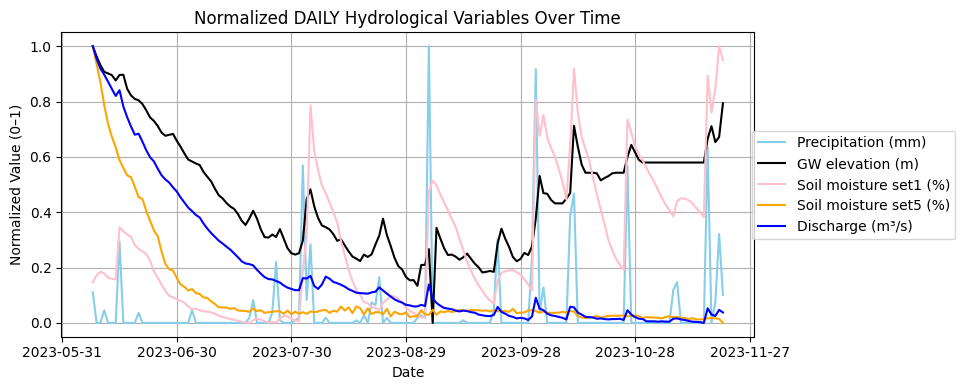

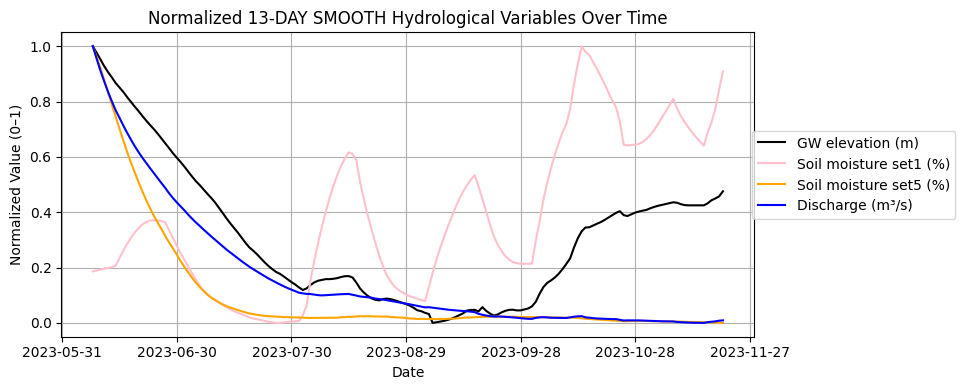

In [4]:

# Min-max normalization
GW_norm = (outfd['303_gw_elev'] - outfd['303_gw_elev'].min()) / (outfd['303_gw_elev'].max() - outfd['303_gw_elev'].min())
SM_norm = (outfd['Daily_sm_set1'] - outfd['Daily_sm_set1'].min()) / (outfd['Daily_sm_set1'].max() - outfd['Daily_sm_set1'].min())
SM_norm5 = (outfd['Daily_sm_set5'] - outfd['Daily_sm_set5'].min()) / (outfd['Daily_sm_set5'].max() - outfd['Daily_sm_set5'].min())
DS_norm = (outfd['Daily_DS_cm'] - outfd['Daily_DS_cm'].min()) / (outfd['Daily_DS_cm'].max() - outfd['Daily_DS_cm'].min())
Pc_norm = (outfd['Daily_precip_mm'] - outfd['Daily_precip_mm'].min()) / (outfd['Daily_precip_mm'].max() - outfd['Daily_precip_mm'].min())

SMOOTH_GW_norm = (outfd['13D_smooth_GW303_m'] - outfd['13D_smooth_GW303_m'].min()) / (outfd['13D_smooth_GW303_m'].max() - outfd['13D_smooth_GW303_m'].min())
SMOOTH_SM_norm1 = (outfd['13D_sm_set1'] - outfd['13D_sm_set1'].min()) / (outfd['13D_sm_set1'].max() - outfd['13D_sm_set1'].min())
SMOOTH_SM_norm5 = (outfd['13D_sm_set5'] - outfd['13D_sm_set5'].min()) / (outfd['13D_sm_set5'].max() - outfd['13D_sm_set5'].min())
SMOOTH_DS_norm = (outfd['13D_smooth_DS_cm'] - outfd['13D_smooth_DS_cm'].min()) / (outfd['13D_smooth_DS_cm'].max() - outfd['13D_smooth_DS_cm'].min())
# SMOOTH_Pc_norm = (outfd['Daily_precip_mm'] - outfd['Daily_precip_mm'].min()) / (outfd['Daily_precip_mm'].max() - outfd['Daily_precip_mm'].min())


plt.figure(figsize=(10,4))   
# Plot normalized values
plt.plot(outfd['date'], Pc_norm, label='Precipitation (mm)', color='skyblue', )
plt.plot(outfd['date'], GW_norm, label='GW elevation (m)', color='k')
plt.plot(outfd['date'], SM_norm, label='Soil moisture set1 (%)', color='pink')
plt.plot(outfd['date'], SM_norm5, label='Soil moisture set5 (%)', color='orange')
plt.plot(outfd['date'], DS_norm, label='Discharge (m³/s)', color='blue')

plt.legend(loc="upper right", bbox_to_anchor=(1.3,0.7))
plt.xlabel('Date')
plt.ylabel('Normalized Value (0–1)')
plt.title('Normalized DAILY Hydrological Variables Over Time')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,4))   
# Plot normalized values
plt.plot(outfd['date'], SMOOTH_GW_norm, label='GW elevation (m)', color='k')
plt.plot(outfd['date'], SMOOTH_SM_norm1, label='Soil moisture set1 (%)', color='pink')
plt.plot(outfd['date'], SMOOTH_SM_norm5, label='Soil moisture set5 (%)', color='orange')
plt.plot(outfd['date'], SMOOTH_DS_norm, label='Discharge (m³/s)', color='blue')

plt.legend(loc="upper right", bbox_to_anchor=(1.3,0.7))
plt.xlabel('Date')
plt.ylabel('Normalized Value (0–1)')
plt.title('Normalized 13-DAY SMOOTH Hydrological Variables Over Time')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
seis_sta=pd.read_csv('redbutte_sta.csv')
seis_sta['stnm']=seis_sta['stnm'].astype(int).apply(lambda i: f"{i:03}")
seis_sta=seis_sta[:-1] 
print(seis_sta)

output_path="Results_prefilt_20Hz_coefs//DVAVE_c2wei/ST/SC/"
bandlist=['4-8','2-4',]

  stnm        lat         lon    elev
0  002  40.794796 -111.779490  1868.0
1  001  40.794836 -111.779309  1868.0
2  003  40.794740 -111.779110  1847.0
3  004  40.794670 -111.778810  1847.0
4  005  40.794660 -111.778630  1847.0
5  006  40.794660 -111.778400  1847.0


In [6]:
# 002 -> N051
# 001 -> N037
# 003 -> N018
# 004 -> S009
# 005 -> S024
# 006 -> S043

# Mapping dictionary
rename_map = {
    "002": "N051",
    "001": "N037",
    "003": "N018",
    "004": "S009",
    "005": "S024",
    "006": "S043"
}

# Example: renaming a list of station codes
stations = ["002", "001", "003", "004", "005", "006"]

renamed_stations = [rename_map[st] for st in stations]
print(renamed_stations)
# Output: ['N037', 'N051', 'N018', 'S009', 'S024', 'S043']
seis_sta['stnm_renamed']=renamed_stations
print(seis_sta)


['N051', 'N037', 'N018', 'S009', 'S024', 'S043']
  stnm        lat         lon    elev stnm_renamed
0  002  40.794796 -111.779490  1868.0         N051
1  001  40.794836 -111.779309  1868.0         N037
2  003  40.794740 -111.779110  1847.0         N018
3  004  40.794670 -111.778810  1847.0         S009
4  005  40.794660 -111.778630  1847.0         S024
5  006  40.794660 -111.778400  1847.0         S043


In [7]:
stnm='004'
renamed=seis_sta.loc[seis_sta['stnm']==stnm, 'stnm_renamed'].values[0]
fband='2-4'
coef='0.6'
# fn_pattern=f'{output_path}/dv_ave_*_{stnm}_*_F{fband}*.out'
fn_pattern = f'{output_path}/dv_ave_*_coef{coef}_{stnm}_*_F{fband}*.out'
fn=glob.glob(fn_pattern)
pd_dv = pd.read_csv(
    fn[0], 
    sep='\s+', 
    names=['dv', 'err', 'date', 'sta1', 'sta2', 'jday'], 
    skiprows=0
)
pd_dv['dv']=pd_dv['dv']*100
pd_dv['err']=pd_dv['err']*100
# Convert the 'date' column to datetime
pd_dv['date'] = pd.to_datetime(pd_dv['date'], format='%Y%m%d')
errcut=0.4
filtered_dv = pd_dv[pd_dv['err'] <= errcut]
df24= filtered_dv.copy()

fband='4-8'
fn_pattern = f'{output_path}/dv_ave_*_coef{coef}_{stnm}_*_F{fband}*.out'
fn=glob.glob(fn_pattern)
pd_dv = pd.read_csv(
    fn[0], 
    sep='\s+', 
    names=['dv', 'err', 'date', 'sta1', 'sta2', 'jday'], 
    skiprows=0
)
pd_dv['dv']=pd_dv['dv']*100
pd_dv['err']=pd_dv['err']*100
# Convert the 'date' column to datetime
pd_dv['date'] = pd.to_datetime(pd_dv['date'], format='%Y%m%d')
errcut=0.4
filtered_dv = pd_dv[pd_dv['err'] <= errcut]
df48= filtered_dv.copy()

In [8]:
# First make sure date columns are datetime (if not already)
outfd['date'] = pd.to_datetime(outfd['date'])
df24['date'] = pd.to_datetime(df24['date'])
df48['date'] = pd.to_datetime(df48['date'])

# Merge the dv values into outfd based on matching date
df = outfd.copy()
df = df.merge(df24[['date', 'dv']], on='date', how='left')  # add dv_2_4Hz
df = df.rename(columns={'dv': 'dv_2_4Hz'})

df = df.merge(df48[['date', 'dv']], on='date', how='left')  # add dv_4_8Hz
df = df.rename(columns={'dv': 'dv_4_8Hz'})
df=df.dropna()

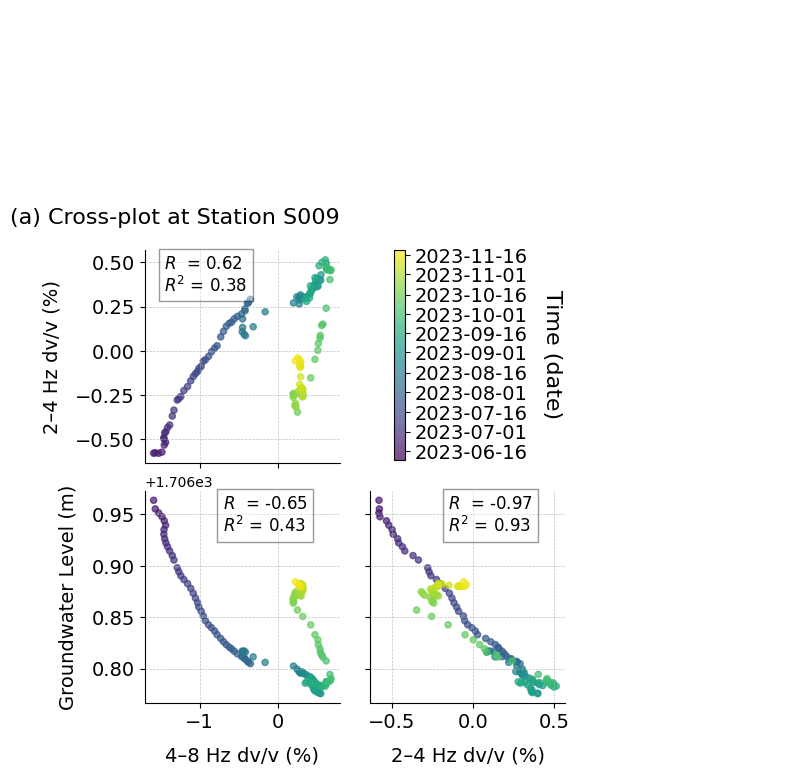

In [41]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import seaborn as sns
from scipy.stats import linregress

# Clean the data
# df_corr = df[['datetime', 'dv_2_4Hz', 'dv_4_8Hz',  '13D_smooth_GW303_m',  '13D_smooth_DS_cm','13D_sm_set1', '13D_sm_set5',]].dropna()

df_corr = df[['datetime',  'dv_4_8Hz', 'dv_2_4Hz', '13D_smooth_GW303_m', ]].dropna()


# Make sure datetime is parsed correctly
df_corr['datetime'] = pd.to_datetime(df_corr['datetime'])
df_corr['timestamp'] = df_corr['datetime'].map(lambda x: x.timestamp())

# Define your custom date range as strings
bound_dates = ['2023-06-09', '2023-11-20']
# Convert to datetime and then to timestamps
bound_timestamps = [pd.to_datetime(d).timestamp() for d in bound_dates]
# Unpack the min and max for Normalize
norm = Normalize(vmin=bound_timestamps[0], vmax=bound_timestamps[1])
cmap = plt.get_cmap("viridis")
colors = df_corr['datetime'].apply(lambda dt: cmap(norm(dt.timestamp())))


# Update plotting function
def scatter_with_stats(x, y, color_values=None, **kwargs):
    ax = plt.gca()
    
    # Scatter with color
    scatter = ax.scatter(x, y, c=color_values, s=20, alpha=0.7, )
    # plt.setp(scatter, edgecolor='grey', linewidth=0.25, )
    
    # Regression line
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    # ax.plot(x_vals, y_vals, color='red', linewidth=1)
    
    # Annotate R
    r2 = r_value**2
    # label = f"Slope={slope:.2f}\nR={r_value:.2f}"
    # label = f"$R^2 = {r2:.2f}$\n$R = {r_value:.2f}$"
    # label = f"Corr = {r_value:.2f}"

    # Line
    # x_vals = np.array(ax.get_xlim())
    # y_vals = intercept + slope * x_vals
    # ax.plot(x_vals, y_vals, color='red', linewidth=1)

    # === Annotation text ===
    label = (
        f"$R$  = {r_value:.2f}\n"
        f"$R^2$ = {r2:.2f}"
        # f"$p$ = {p_value:.2e}"
    )
    
    # pick position automatically
    if r_value <0:
        x, y = 0.4, 0.98   # top-right
    if r_value > 0.7:
        x, y = 0.4,0.25
    if r_value > 0.3 and r_value <= 0.7:
        x, y = 0.1,0.98
    if r_value > 0 and r_value <= 0.3:
        x, y = 0.5, 0.95   
    ax.text(x, y, label, transform=ax.transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.4))


# Create PairGrid with coloring
plot_vars = [ 'dv_4_8Hz','dv_2_4Hz', '13D_smooth_GW303_m', ]
g = sns.PairGrid(df_corr, vars=plot_vars, diag_sharey=False, height=2, aspect=1.2)
g.map_lower(lambda x, y, **kwargs: scatter_with_stats(x, y,s =30, color_values=colors.loc[x.index], **kwargs))
# g.map_diag(sns.histplot, kde=True, color='skyblue')
g.map_diag(lambda *args, **kwargs: None)  # do nothing on diagonal

# Hide upper triangle
for i in range(len(g.axes)):
    for j in range(len(g.axes)):
        if j >= i:
            g.axes[i, j].set_visible(False)

# Label font size
for ax in g.axes.flatten():
    if ax:
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)
        ax.tick_params(labelsize=14)

# plt.suptitle(f"Station {renamed} ", y=1.02)

# Create ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])


# === Add single shared colorbar ===
cbar_ax = g.fig.add_axes([0.45, 0.5, 0.015, 0.35])  # [left, bottom, width, height]
sm = ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, cax=cbar_ax, alpha=0.7)
# 1. Define your custom tick dates
# Create date ranges for the 1st and 16th of each month
start_dates = pd.date_range(start="2023-06-08", end="2023-11-20", freq='MS')
mid_dates = pd.date_range(start="2023-06-01", end="2023-11-16", freq='MS') + pd.Timedelta(days=15)

# Combine and sort
custom_dates = start_dates.union(mid_dates).sort_values()

# 2. Convert to timestamps (for tick positions)
tick_vals = custom_dates.map(lambda dt: dt.timestamp())
# 3. Format labels nicely
tick_labels = custom_dates.strftime('%Y-%m-%d')

cbar.set_ticks(tick_vals)
cbar.set_ticklabels(tick_labels, fontsize=14)
cbar.set_label("Time (date)", rotation=270, labelpad=10, fontsize=16, va='bottom')

label_map = {
    "dv_2_4Hz": "2–4 Hz dv/v (%)",
    "dv_4_8Hz": "4–8 Hz dv/v (%)",
    "13D_smooth_GW303_m": "Groundwater Level (m)"
}


# Final layout
g.fig.subplots_adjust(top=1.25, right=1,)
g.fig.suptitle(f"(a) Cross-plot at Station {renamed} ",  y=0.92, x=0.15, fontsize=16)
# Adjust label padding
for ax in g.axes.flatten():
    xlabel = ax.get_xlabel()
    ylabel = ax.get_ylabel()
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.8)
    if xlabel in label_map:
        ax.set_xlabel(label_map[xlabel], labelpad=10)
    if ylabel in label_map:
        ax.set_ylabel(label_map[ylabel], labelpad=10)

# plt.show()
plt.savefig(f"Fig_S009_pairgrid.png", dpi=300, bbox_inches='tight')


In [31]:
def plot_resid(df, **kwargs):
    df['datetime']=pd.to_datetime(df['datetime'])
    # 4. Plot the original data, fitting results, and residuals
    plt.figure(figsize=(12,8))

    # Original Data and Fitting Results for dv_2_4Hz
    plt.subplot(3, 2, 3)
    plt.grid(True, color='grey', linestyle='--', linewidth=0.5)
    plt.axhline(0, color='grey', linestyle='-')   
    plt.gca().invert_yaxis()
    plt.plot(df['datetime'], df['dv_2_4Hz'], '.', markersize=5, linestyle='-', linewidth=0.5 ,alpha=0.7,
             label='Observed dv/v', color='blue')
    plt.plot(df['datetime'], df['dv_pred_2_4'], '.', markersize=5, linestyle='-', linewidth=0.5 ,alpha=0.7,
             label='Modeling dv/v by GWL', color='orange')
    plt.plot(df['datetime'], df['residuals_2_4'],'.', markersize=5, linestyle='-', linewidth=0.5 ,alpha=0.7,
             label='Residuals', color='red')

    plt.title('(c) Modeling of dv/v at deep depths (2-4 Hz)', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('dv/v (%)', fontsize=14)
    plt.legend(loc="upper right",)

    # Original Data and Fitting Results for dv_4_8Hz
    plt.subplot(3, 2, 1)
    plt.grid(True, color='grey', linestyle='--', linewidth=0.5) 
    plt.axhline(0, color='grey', linestyle='-')   
    plt.gca().invert_yaxis()
    plt.plot(df['datetime'], df['dv_4_8Hz'],'.', markersize=5, linestyle='-', linewidth=0.5 , alpha=0.7,
             label='Observed dv/v', color='blue')
    plt.plot(df['datetime'], df['dv_pred_4_8'], '.', markersize=5, linestyle='-', linewidth=0.5 ,alpha=0.7,
             label='Modeling dv/v by GWL', color='orange', )
    plt.plot(df['datetime'], df['residuals_4_8'],'.', markersize=5, linestyle='-', linewidth=0.5 , alpha=0.7,
             label='Residuals ', color='red')
    
    plt.title('(b) Modeling of dv/v at shallow depths (4-8 Hz)', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('dv/v (%)', fontsize=14)
    plt.legend()


    # Display the plots
    plt.tight_layout()
    plt.savefig(f"Fig_S009_dvv_modeling.png", dpi=300, bbox_inches='tight')


Index(['13D_smooth_GW303_m'], dtype='object')
Index(['13D_smooth_GW303_m'], dtype='object') [-5.99608253] 10234.386459007257
Coefficients for dv_2_4Hz model:
13D_smooth_GW303_m coef: -5.9961
Intercept: 10234.3865

Coefficients for dv_4_8Hz model:
13D_smooth_GW303_m: -9.3680
Intercept: 15989.5974


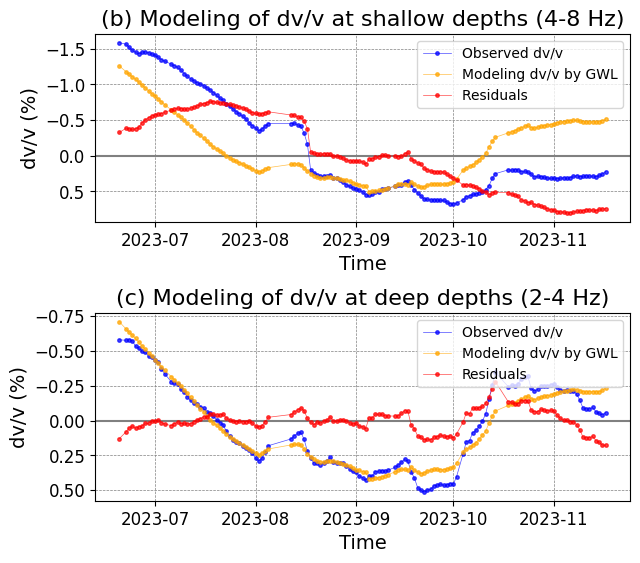

In [17]:
dftmp=df.copy()
# Perform linear regression to model dv_2_4Hz and dv_4_8Hz as functions of GWL
# Model 1: dv_2_4Hz as a function of GWL
X_gwl = dftmp[['13D_smooth_GW303_m']]
y_2_4 = dftmp['dv_2_4Hz']

# Fit the model
model_2_4 = LinearRegression()
model_2_4.fit(X_gwl, y_2_4)

# Model 2: dv_4_8Hz as a function of GWL
y_4_8 = dftmp['dv_4_8Hz']
model_4_8 = LinearRegression()
model_4_8.fit(X_gwl, y_4_8)

# Predict dv_2_4Hz and dv_4_8Hz using both models
dftmp['dv_pred_2_4'] = model_2_4.predict(X_gwl)
dftmp['dv_pred_4_8'] = model_4_8.predict(X_gwl)

# Calculate residuals for both models
dftmp['residuals_2_4'] = dftmp['dv_2_4Hz'] - dftmp['dv_pred_2_4']
dftmp['residuals_4_8'] = dftmp['dv_4_8Hz'] - dftmp['dv_pred_4_8']


# Get the list of predictor names
predictors = X_gwl.columns
print(predictors)
print(predictors, model_2_4.coef_, model_2_4.intercept_)

# Print the coefficients with corresponding variable names
print("Coefficients for dv_2_4Hz model:")
for name, coef in zip(predictors, model_2_4.coef_):
    print(f"{name} coef: {coef:.4f}")
    print(f"Intercept: {model_2_4.intercept_:.4f}")

print("\nCoefficients for dv_4_8Hz model:")
for name, coef in zip(predictors, model_4_8.coef_):
    print(f"{name}: {coef:.4f}")
    print(f"Intercept: {model_4_8.intercept_:.4f}")

plot_resid(dftmp,)

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
def plot_forward_model_oppo(df,fitdate, **kwargs):
    df['datetime'] = pd.to_datetime(df['datetime'])

    plt.figure(figsize=(14, 3))

    # Plot dv_4_8Hz and forward model
    plt.subplot(1, 2, 1)
    plt.gca().invert_yaxis()
    plt.plot(df['datetime'], df['dv_2_4Hz'], '.', markersize=3, linestyle='-', linewidth=0.5,
             label='Observed dv_2-4Hz', color='blue')
    plt.plot(df['datetime'], df['dv_pred_2_4'], '.', markersize=3, linestyle='-', linewidth=0.5,
             label='Forward Model dv_2-4Hz (from dv_4-8)', color='orange')
    plt.axvspan(pd.to_datetime(fitdate), df['datetime'].max(), color='gray', alpha=0.1,
                label='Fitting Period')
    plt.title(f'Forward Model of dv_2-4Hz using dv_4-8 Coeff (from post-{fitdate})')
    plt.xlabel('Date')
    plt.ylabel('dv_2-4Hz')
    plt.legend()

    # Residuals from forward model
    plt.subplot(1, 2, 2)
    plt.gca().invert_yaxis()
    df['forward_residuals_2_4'] = df['dv_2_4Hz'] - df['dv_pred_2_4']
    plt.plot(df['datetime'], df['forward_residuals_2_4'], '.', markersize=3, linestyle='-', linewidth=0.5,
             label='Residuals (Observed - Forward Model)', color='red')
    plt.axhline(0, color='grey', linestyle='-')
    plt.title('Residuals from Forward Model (dv_2-4Hz)')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))

    # Overlay SM time series
    plt.twinx()
    plt.plot(df['datetime'], df['13D_sm_set1'], '.', markersize=3, linestyle='-', linewidth=0.5,
             label='13-D SM top-5cm(%)', color='royalblue')
    plt.plot(df['datetime'], df['13D_sm_set5'], '.', markersize=3, linestyle='-', linewidth=0.5,
             label='13-D SM top-1m(%)', color='darkblue')
    plt.ylabel('Top 5-cm daily SM(%)', color='royalblue')
    plt.tick_params(axis='y', labelcolor='royalblue')
    plt.legend(loc="upper right", bbox_to_anchor=(1.5, 0.8))

    # Display the plots
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_forward_model(df,fitdate, **kwargs):
    df['datetime'] = pd.to_datetime(df['datetime'])

    plt.figure(figsize=(14, 3))

    # Plot dv_4_8Hz and forward model
    plt.subplot(1, 2, 1)
    plt.gca().invert_yaxis()
    plt.plot(df['datetime'], df['dv_4_8Hz'], '.', markersize=3, linestyle='-', linewidth=0.5,
             label='Observed dv_4_8Hz', color='blue')
    plt.plot(df['datetime'], df['dv_pred_4_8'], '.', markersize=3, linestyle='-', linewidth=0.5,
             label='Forward Model dv_4_8Hz (from GWL)', color='orange')
    plt.axvspan(pd.to_datetime(fitdate), df['datetime'].max(), color='gray', alpha=0.1,
                label='Fitting Period')
    plt.title(f'Forward Model of dv_4_8Hz using GWL Coeff (from post-{fitdate})')
    plt.xlabel('Date')
    plt.ylabel('dv_4_8Hz')
    plt.legend()

    # Residuals from forward model
    plt.subplot(1, 2, 2)
    plt.gca().invert_yaxis()
    df['forward_residuals_4_8'] = df['dv_4_8Hz'] - df['dv_pred_4_8']
    plt.plot(df['datetime'], df['forward_residuals_4_8'], '.', markersize=3, linestyle='-', linewidth=0.5,
             label='Residuals (Observed - Forward Model)', color='red')
    plt.axhline(0, color='grey', linestyle='-')
    plt.title('Residuals from Forward Model (dv_4_8Hz)')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))

    # Overlay SM time series
    plt.twinx()
    plt.plot(df['datetime'], df['13D_sm_set1'], '.', markersize=3, linestyle='-', linewidth=0.5,
             label='13-D SM top-5cm(%)', color='royalblue')
    plt.plot(df['datetime'], df['13D_sm_set5'], '.', markersize=3, linestyle='-', linewidth=0.5,
             label='13-D SM top-1m(%)', color='darkblue')
    plt.ylabel('Top 5-cm daily SM(%)', color='royalblue')
    plt.tick_params(axis='y', labelcolor='royalblue')
    plt.legend(loc="upper right", bbox_to_anchor=(1.5, 0.8))

    # Display the plots
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_forward_model_early(df,fitdate, **kwargs):
    df['datetime'] = pd.to_datetime(df['datetime'])

    plt.figure(figsize=(14, 3))

    # Plot dv_4_8Hz and forward model
    plt.subplot(1, 2, 1)
    plt.gca().invert_yaxis()
    plt.plot(df['datetime'], df['dv_4_8Hz'], '.', markersize=3, linestyle='-', linewidth=0.5,
             label='Observed dv_4_8Hz', color='blue')
    plt.plot(df['datetime'], df['dv_pred_4_8'], '.', markersize=3, linestyle='-', linewidth=0.5,
             label='Forward Model dv_4_8Hz (from GWL)', color='orange')
    plt.axvspan( df['datetime'].min(),pd.to_datetime(fitdate), color='gray', alpha=0.1,
                label='Fitting Period')
    plt.title(f'Forward Model of dv_4_8Hz using GWL Coeff (from prior to-{fitdate})')
    plt.xlabel('Date')
    plt.ylabel('dv_4_8Hz')
    plt.legend()

    # Residuals from forward model
    plt.subplot(1, 2, 2)
    plt.gca().invert_yaxis()
    df['forward_residuals_4_8'] = df['dv_4_8Hz'] - df['dv_pred_4_8']
    plt.plot(df['datetime'], df['forward_residuals_4_8'], '.', markersize=3, linestyle='-', linewidth=0.5,
             label='Residuals (Observed - Forward Model)', color='red')
    plt.axhline(0, color='grey', linestyle='-')
    plt.title('Residuals from Forward Model (dv_4_8Hz)')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))

    # Overlay SM time series
    plt.twinx()
    plt.plot(df['datetime'], df['13D_sm_set1'], '.', markersize=3, linestyle='-', linewidth=0.5,
             label='13-D SM top-5cm(%)', color='royalblue')
    plt.plot(df['datetime'], df['13D_sm_set5'], '.', markersize=3, linestyle='-', linewidth=0.5,
             label='13-D SM top-1m(%)', color='darkblue')
    plt.ylabel('Top 5-cm daily SM(%)', color='royalblue')
    plt.tick_params(axis='y', labelcolor='royalblue')
    plt.legend(loc="upper right", bbox_to_anchor=(1.5, 0.8))

    # Display the plots
    plt.tight_layout()
    plt.show()


Index(['dv_2_4Hz'], dtype='object')

Coefficients for dv_4_8Hz model:
dv_2_4Hz: 1.5134
Intercept: -0.6571


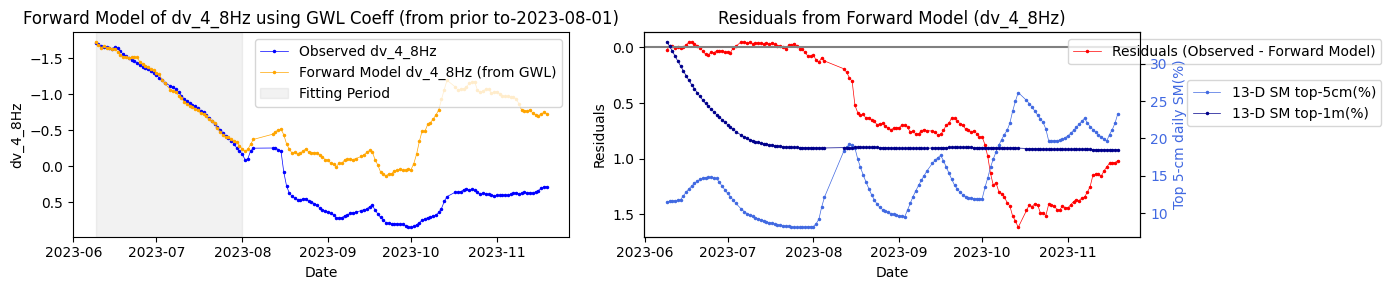

In [ ]:
dftmp4=df.copy()
fitdate='2023-08-01'
dftmp4=dftmp4[dftmp4['datetime'] <= fitdate]
# Perform linear regression to model dv_2_4Hz and dv_4_8Hz as functions of GWL

# Model 2: dv_4_8Hz as a function of GWL
X_gwl = dftmp4[['dv_2_4Hz']]
y_4_8 = dftmp4['dv_4_8Hz']
model_4_8 = LinearRegression()
model_4_8.fit(X_gwl, y_4_8)

# Predict dv_4_8Hz using dv_2_4Hz
dftmp4['dv_pred_4_8'] = model_4_8.predict(X_gwl)

# Calculate residuals for both models
dftmp4['residuals_4_8'] = dftmp4['dv_4_8Hz'] - dftmp4['dv_pred_4_8']


# Get the list of predictor names
predictors = X_gwl.columns
print(predictors)


print("\nCoefficients for dv_4_8Hz model:")
for name, coef in zip(predictors, model_4_8.coef_):
    print(f"{name}: {coef:.4f}")
    print(f"Intercept: {model_4_8.intercept_:.4f}")
    
# forward to model the 4-8 Hz dv/v using the coef from the data after 2023-10-01. 
# Use the coefficient and intercept from the post-2023-10-01 model
coef_4_8 = model_4_8.coef_[0]
intercept_4_8 = model_4_8.intercept_

# Create a new column for the forward-modeled dv/v using the GWL
dftmp['dv_pred_4_8'] = intercept_4_8 + coef_4_8 * dftmp['dv_2_4Hz']



    
plot_forward_model_early(dftmp,fitdate,)

Index(['dv_2_4Hz'], dtype='object')

Coefficients for dv_4_8Hz model:
dv_2_4Hz: 0.5322
Intercept: 0.5123


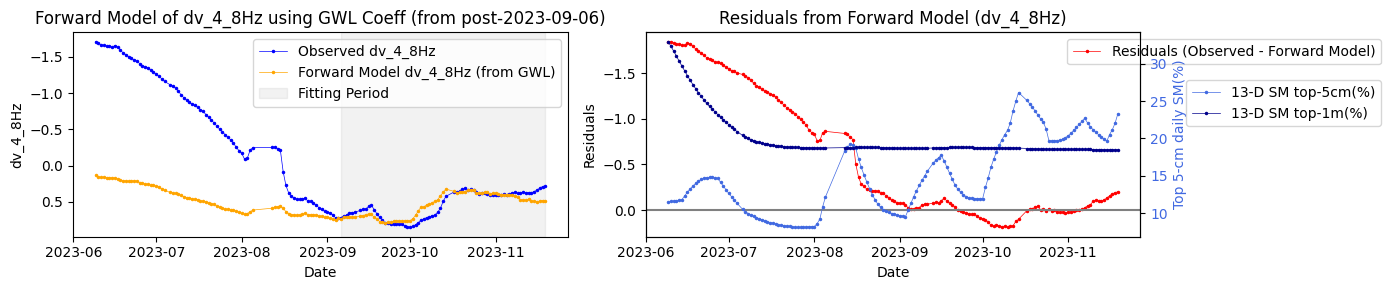

In [ ]:
dftmp3=df.copy()
fitdate='2023-09-06'
dftmp3=dftmp3[dftmp3['datetime'] >= fitdate]
# Perform linear regression to model dv_2_4Hz and dv_4_8Hz as functions of GWL

# Model 2: dv_4_8Hz as a function of GWL
X_gwl = dftmp3[['dv_2_4Hz']]
y_4_8 = dftmp3['dv_4_8Hz']
model_4_8 = LinearRegression()
model_4_8.fit(X_gwl, y_4_8)

# Predict dv_4_8Hz using dv_2_4Hz
dftmp3['dv_pred_4_8'] = model_4_8.predict(X_gwl)

# Calculate residuals for both models
dftmp3['residuals_4_8'] = dftmp3['dv_4_8Hz'] - dftmp3['dv_pred_4_8']


# Get the list of predictor names
predictors = X_gwl.columns
print(predictors)


print("\nCoefficients for dv_4_8Hz model:")
for name, coef in zip(predictors, model_4_8.coef_):
    print(f"{name}: {coef:.4f}")
    print(f"Intercept: {model_4_8.intercept_:.4f}")
    
# forward to model the 4-8 Hz dv/v using the coef from the data after 2023-10-01. 
# Use the coefficient and intercept from the post-2023-10-01 model
coef_4_8 = model_4_8.coef_[0]
intercept_4_8 = model_4_8.intercept_

# Create a new column for the forward-modeled dv/v using the GWL
dftmp['dv_pred_4_8'] = intercept_4_8 + coef_4_8 * dftmp['dv_2_4Hz']



    
plot_forward_model(dftmp,fitdate,)

Index(['dv_4_8Hz'], dtype='object')

Coefficients for dv_2_4Hz model:
dv_4_8Hz: 1.3831
Intercept: -0.6931


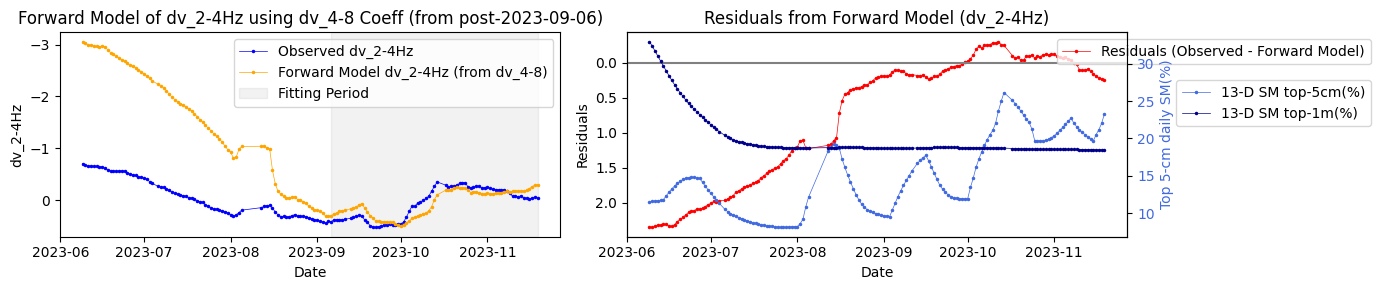

In [ ]:
dftmp5=df.copy()
fitdate='2023-09-06'
dftmp5=dftmp5[dftmp5['datetime'] >= fitdate]
# Perform linear regression to model dv_2_4Hz and dv_4_8Hz as functions of GWL

# Model 2: dv_4_8Hz as a function of GWL
X_gwl = dftmp5[['dv_4_8Hz']]
y_2_4 = dftmp5['dv_2_4Hz']
model_2_4 = LinearRegression()
model_2_4.fit(X_gwl, y_2_4)

# Predict dv_4_8Hz using dv_2_4Hz
dftmp5['dv_pred_2_4'] = model_2_4.predict(X_gwl)

# Calculate residuals for both models
dftmp5['residuals_2_4'] = dftmp5['dv_2_4Hz'] - dftmp5['dv_pred_2_4']


# Get the list of predictor names
predictors = X_gwl.columns
print(predictors)


print("\nCoefficients for dv_2_4Hz model:")
for name, coef in zip(predictors, model_2_4.coef_):
    print(f"{name}: {coef:.4f}")
    print(f"Intercept: {model_2_4.intercept_:.4f}")
    
# forward to model the 4-8 Hz dv/v using the coef from the data after 2023-10-01. 
# Use the coefficient and intercept from the post-2023-10-01 model
coef_2_4 = model_2_4.coef_[0]
intercept_2_4 = model_2_4.intercept_

# Create a new column for the forward-modeled dv/v using the GWL
dftmp['dv_pred_2_4'] = intercept_2_4 + coef_2_4 * dftmp['dv_4_8Hz']



    
plot_forward_model_oppo(dftmp,fitdate,)

Index(['13D_smooth_GW303_m'], dtype='object')
Coefficients for dv_2_4Hz model:
13D_smooth_GW303_m: -6.7037

Coefficients for dv_4_8Hz model:
13D_smooth_GW303_m: -5.0819


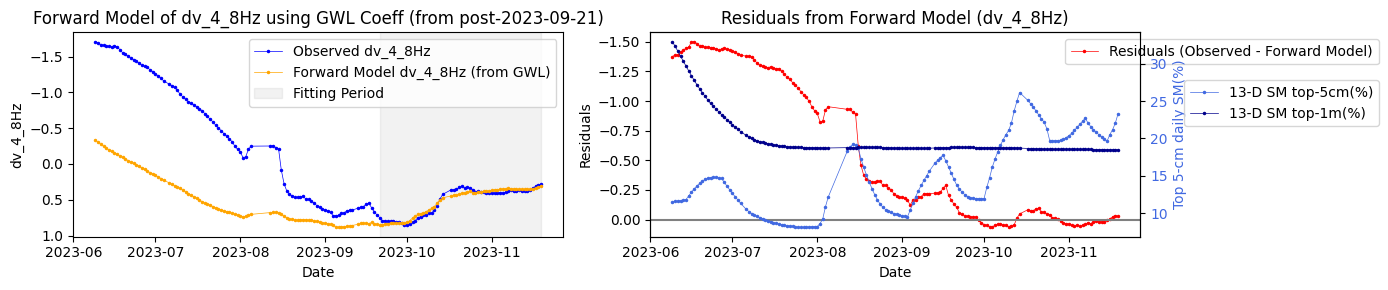

In [ ]:
dftmp2=df.copy()
fitdate='2023-09-21'
dftmp2=dftmp2[dftmp2['datetime'] >= fitdate]
# Perform linear regression to model dv_2_4Hz and dv_4_8Hz as functions of GWL
# Model 1: dv_2_4Hz as a function of GWL
X_gwl = dftmp2[['13D_smooth_GW303_m']]
y_2_4 = dftmp2['dv_2_4Hz']

# Fit the model
model_2_4 = LinearRegression()
model_2_4.fit(X_gwl, y_2_4)

# Model 2: dv_4_8Hz as a function of GWL
y_4_8 = dftmp2['dv_4_8Hz']
model_4_8 = LinearRegression()
model_4_8.fit(X_gwl, y_4_8)

# Predict dv_2_4Hz and dv_4_8Hz using both models
dftmp2['dv_pred_2_4'] = model_2_4.predict(X_gwl)
dftmp2['dv_pred_4_8'] = model_4_8.predict(X_gwl)

# Calculate residuals for both models
dftmp2['residuals_2_4'] = dftmp2['dv_2_4Hz'] - dftmp2['dv_pred_2_4']
dftmp2['residuals_4_8'] = dftmp2['dv_4_8Hz'] - dftmp2['dv_pred_4_8']


# Get the list of predictor names
predictors = X_gwl.columns
print(predictors)

# Print the coefficients with corresponding variable names
print("Coefficients for dv_2_4Hz model:")
for name, coef in zip(predictors, model_2_4.coef_):
    print(f"{name}: {coef:.4f}")

print("\nCoefficients for dv_4_8Hz model:")
for name, coef in zip(predictors, model_4_8.coef_):
    print(f"{name}: {coef:.4f}")
    
    
# forward to model the 4-8 Hz dv/v using the coef from the data after 2023-10-01. 
# Use the coefficient and intercept from the post-2023-10-01 model
coef_4_8 = model_4_8.coef_[0]
intercept_4_8 = model_4_8.intercept_

# Create a new column for the forward-modeled dv/v using the GWL
dftmp['dv_pred_4_8'] = intercept_4_8 + coef_4_8 * dftmp['13D_smooth_GW303_m']



    
plot_forward_model(dftmp,fitdate,)

In [ ]:
dffit=dftmp.copy()
dffit.head(5)

,datetime,Daily_DS_cm,13D_smooth_DS_cm,Daily_sm_set1,Daily_sm_set5,13D_sm_set1,13D_sm_set5,301_gw_elev,302_gw_elev,303_gw_elev,...,Daily_precip_mm,date,dv_2_4Hz,dv_4_8Hz,dv_pred_2_4,dv_pred_4_8,residuals_2_4,residuals_4_8,forward_residuals_4_8,forward_residuals_2_4
1,2023-06-09,0.2860,0.3655,12.62,29.14,11.4831,32.9538,1707.6733,1707.4177,1706.9840,...,0.00,2023-06-09,-0.7090,-1.7091,-3.056966,-0.334675,0.186400,0.084482,-1.374425,2.347966
2,2023-06-10,0.2772,0.3513,12.97,28.36,11.5523,32.3454,1707.6692,1707.4083,1706.9754,...,0.00,2023-06-10,-0.6781,-1.6921,-3.033453,-0.303675,0.184569,0.037024,-1.388425,2.355353
3,2023-06-11,0.2718,0.3383,12.79,27.40,11.6131,31.6908,1707.6529,1707.3990,1706.9688,...,1.27,2023-06-11,-0.6546,-1.6636,-2.994036,-0.273692,0.176410,0.003180,-1.389908,2.339436
4,2023-06-12,0.2656,0.3262,12.37,26.62,11.6569,31.0038,1707.6421,1707.3958,1706.9673,...,0.00,2023-06-12,-0.6658,-1.6577,-2.985875,-0.246758,0.136771,-0.046923,-1.410942,2.320075
5,2023-06-13,0.2591,0.3148,12.27,26.07,11.7092,30.3415,1707.6325,1707.3910,1706.9656,...,0.00,2023-06-13,-0.6516,-1.6492,-2.974119,-0.222873,0.125752,-0.088087,-1.426327,2.322519


Most negative correlation: -0.6158 at lag 33 days


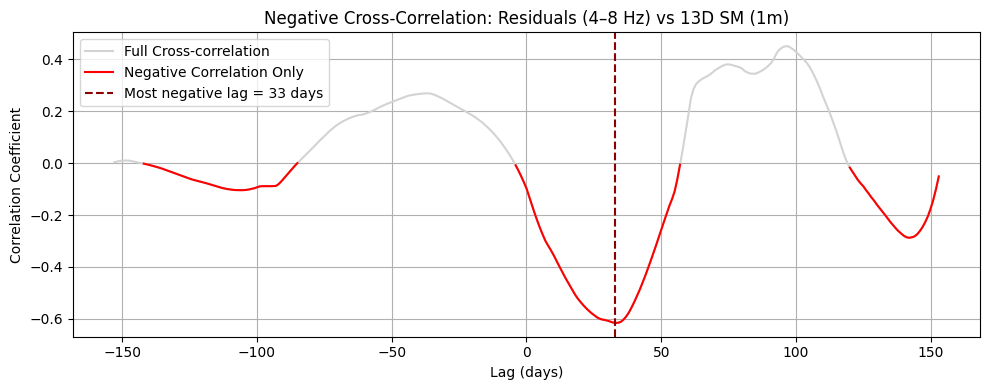

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import correlate, detrend
import matplotlib.pyplot as plt

# Prepare the data: drop NaNs and align
dffit['datetime'] = pd.to_datetime(dffit['datetime'])
df_corr = dffit[['datetime', 'forward_residuals_4_8', '13D_sm_set5']].dropna()

# Detrend and normalize
resid = detrend(df_corr['forward_residuals_4_8'].values)
sm = detrend(df_corr['13D_sm_set5'].values)
resid = (resid - np.mean(resid)) / np.std(resid)
sm = (sm - np.mean(sm)) / np.std(sm)

# Cross-correlation
corr = correlate(resid, sm, mode='full')
lags = np.arange(-len(resid) + 1, len(resid))
corr /= len(resid)  # normalize correlation

# Mask to only look at negative correlations
neg_corr = corr.copy()
neg_corr[neg_corr > 0] = np.nan  # mask out positive correlations

# Find the lag with the most negative correlation
min_corr_idx = np.nanargmin(neg_corr)
best_lag = lags[min_corr_idx]
min_corr = neg_corr[min_corr_idx]

print(f"Most negative correlation: {min_corr:.4f} at lag {best_lag} days")
plt.figure(figsize=(10, 4))
plt.plot(lags, corr, label='Full Cross-correlation', color='lightgray')
plt.plot(lags, neg_corr, label='Negative Correlation Only', color='red')
plt.axvline(best_lag, color='darkred', linestyle='--', label=f'Most negative lag = {best_lag} days')
plt.title("Negative Cross-Correlation: Residuals (4–8 Hz) vs 13D SM (1m)")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation Coefficient")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Best T: 2023-09-28 | Best decay rate: 0.002 | RMSE: 0.0156


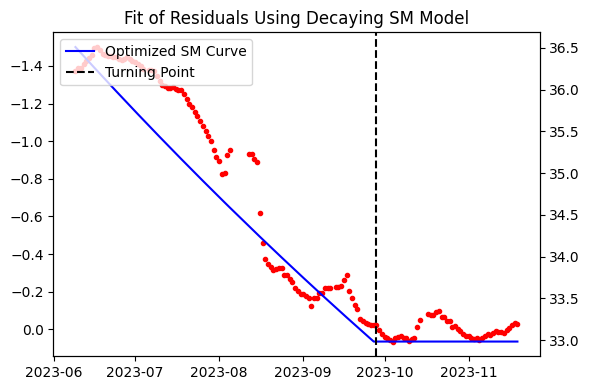

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def build_piecewise_sm(df, turning_date, decay_rate=0.1):
    df = df.copy()
    mask_before = df['datetime'] < turning_date
    mask_after = ~mask_before

    # Get days before turning point as delta
    dt = (turning_date - df.loc[mask_before, 'datetime']).dt.days.astype(float)
    sm_before = df.loc[mask_before, '13D_sm_set5']
    
    if len(sm_before) < 2:
        return None  # skip if not enough data before T

    # Normalize and apply decay
    A = sm_before.max() - sm_before.min()
    B = sm_before.min()
    decay_curve = A * np.exp(decay_rate * dt) + B

    # Construct full piecewise curve
    piecewise = pd.Series(index=df.index, dtype=float)
    piecewise[mask_before] = decay_curve.values
    piecewise[mask_after] = decay_curve.values[-1]  # hold flat

    return piecewise

# Sweep over turning dates and decay rates
turning_dates = pd.date_range('2023-09-15', '2023-11-01')
decay_rates = np.linspace(0.002, 0.5, 50)

best_rmse = np.inf
best_curve = None
best_turn = None
best_decay = None

for T in turning_dates:
    for k in decay_rates:
        curve = build_piecewise_sm(dffit, T, decay_rate=k)
        if curve is None:
            continue
        X = curve.values.reshape(-1, 1)
        y = dffit['forward_residuals_4_8'].values

        # Remove NaNs
        mask = ~np.isnan(X.flatten()) & ~np.isnan(y)
        if mask.sum() < 10:
            continue
        X, y = X[mask], y[mask]

        model = LinearRegression().fit(X, y)
        pred = model.predict(X)
        rmse = mean_squared_error(y, pred, )

        if rmse < best_rmse:
            best_rmse = rmse
            best_curve = curve
            best_turn = T
            best_decay = k

print(f"Best T: {best_turn.strftime('%Y-%m-%d')} | Best decay rate: {best_decay:.3f} | RMSE: {best_rmse:.4f}")

plt.figure(figsize=(6,4))
plt.gca().invert_yaxis()
plt.plot(dffit['datetime'], dffit['forward_residuals_4_8'], '.', label='Forward Residuals (4–8Hz)', color='red')

plt.twinx()
plt.plot(dffit['datetime'], best_curve, '-', label='Optimized SM Curve', color='blue')
plt.axvline(best_turn, color='black', linestyle='--', label='Turning Point')
plt.title("Fit of Residuals Using Decaying SM Model")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


Fitted params:
 A = 2.62
 k = -0.0593
 B = 18.69
 T = 29.06


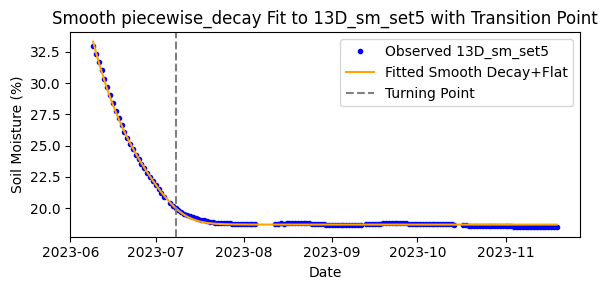

In [ ]:
# ----------------------------------------------------------------
# This cell resolving the function of 13D_sm_set5!!!!!
# ----------------------------------------------------------------
from scipy.optimize import curve_fit

def smooth_piecewise_decay(t, A, k, B, T, width=5):
    # Sigmoid mask for smooth transition
    sigmoid = 1 / (1 + np.exp((t - T) / width))
    decay_part = A * np.exp(k * (t - T)) + B
    flat_part = B
    return sigmoid * decay_part + (1 - sigmoid) * flat_part

# Prepare time and SM values
dffit2 = dffit.copy()
dffit2['datetime'] = pd.to_datetime(dffit2['datetime'])
dffit2 = dffit2.dropna(subset=['13D_sm_set5'])  # remove NaNs

# Convert datetime to float (days since start)
t0 = dffit2['datetime'].min()
dffit2['t_days'] = (dffit2['datetime'] - t0).dt.total_seconds() / (24 * 3600)
t = dffit2['t_days'].values
sm = dffit2['13D_sm_set5'].values


# Time conversion and data
t0 = dffit2['datetime'].iloc[0]
t = (dffit2['datetime'] - t0).dt.total_seconds() / (3600 * 24)  # days
sm = dffit2['13D_sm_set5'].values

# Initial guesses
A0 = sm.max() - sm.min()
k0 = -0.05
B0 = sm.min()
t_array = t.to_numpy()  # convert to numpy array
grad_sm = np.gradient(sm)
T0 = t_array[np.argmax(grad_sm < -0.01)] if np.any(grad_sm < -0.01) else np.median(t_array)

# Bounds
bounds = ([0, -1, 0, t.min()], [2 * A0, -1e-4, sm.max() + 5, t.max()])

# Fit
popt, _ = curve_fit(
    lambda t, A, k, B, T: smooth_piecewise_decay(t, A, k, B, T),
    t_array, sm,
    p0=[A0, k0, B0, T0],
    bounds=bounds,
    maxfev=10000
)


# Extract fitted params
A_fit, k_fit, B_fit, T_fit = popt
print(f"Fitted params:\n A = {A_fit:.2f}\n k = {k_fit:.4f}\n B = {B_fit:.2f}\n T = {T_fit:.2f}")
t_fit = np.linspace(t.min(), t.max(), 500)
sm_fit = smooth_piecewise_decay(t_fit, *popt)
datetime_fit = t0 + pd.to_timedelta(t_fit, unit='D')

plt.figure(figsize=(6, 3))
plt.plot(dffit2['datetime'], sm, '.', label='Observed 13D_sm_set5', color='blue')
plt.plot(datetime_fit, sm_fit, '-', label='Fitted Smooth Decay+Flat', color='orange')
plt.axvline(t0 + pd.to_timedelta(T_fit, unit='D'), color='gray', linestyle='--', label='Turning Point')
plt.xlabel('Date')
plt.ylabel('Soil Moisture (%)')
plt.title('Smooth piecewise_decay Fit to 13D_sm_set5 with Transition Point')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 1. Define the smooth_piecewise_decay function
def smooth_piecewise_decay(t, A, k, B, T, width=5):
    sigmoid = 1 / (1 + np.exp((t - T) / width))
    decay_part = A * np.exp(k * (t - T)) + B
    flat_part = B
    return sigmoid * decay_part + (1 - sigmoid) * flat_part

# 2. Define the pure sigmoid model
def pure_sigmoid(t, A, B, T, width=10):
    return A / (1 + np.exp((t - T) / width)) + B

Fitted params:
 A = 26.52
 k = -0.0593
 B = 18.62
 T = 1.68


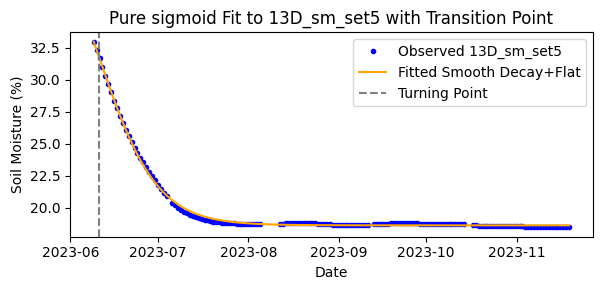

In [ ]:

# Prepare time and SM values
dffit2 = dffit.copy()
dffit2['datetime'] = pd.to_datetime(dffit2['datetime'])
dffit2 = dffit2.dropna(subset=['13D_sm_set5'])  # remove NaNs

# Convert datetime to float (days since start)
t0 = dffit2['datetime'].min()
dffit2['t_days'] = (dffit2['datetime'] - t0).dt.total_seconds() / (24 * 3600)
t = dffit2['t_days'].values
sm = dffit2['13D_sm_set5'].values

# Time conversion and data
t0 = dffit2['datetime'].iloc[0]
t = (dffit2['datetime'] - t0).dt.total_seconds() / (3600 * 24)  # days
sm = dffit2['13D_sm_set5'].values

# Initial guesses
A0 = sm.max() - sm.min()
k0 = -0.05
B0 = sm.min()
t_array = t.to_numpy()  # convert to numpy array
grad_sm = np.gradient(sm)
T0 = t_array[np.argmax(grad_sm < -0.01)] if np.any(grad_sm < -0.01) else np.median(t_array)

# Bounds
bounds = ([0, 0, t.min()], [2 * A0, sm.max() + 5, t.max()])

# Fit
popt, _ = curve_fit(
    lambda t, A, B, T: pure_sigmoid(t, A, B, T),
    t_array, sm,
    p0=[A0, B0, T0],
    bounds=bounds,
    maxfev=10000
)


# Extract fitted params
A_fit, B_fit, T_fit = popt
print(f"Fitted params:\n A = {A_fit:.2f}\n k = {k_fit:.4f}\n B = {B_fit:.2f}\n T = {T_fit:.2f}")
t_fit = np.linspace(t.min(), t.max(), 500)
sm_fit = pure_sigmoid(t_fit, *popt)
datetime_fit = t0 + pd.to_timedelta(t_fit, unit='D')

plt.figure(figsize=(6, 3))
plt.plot(dffit2['datetime'], sm, '.', label='Observed 13D_sm_set5', color='blue')
plt.plot(datetime_fit, sm_fit, '-', label='Fitted Smooth Decay+Flat', color='orange')
plt.axvline(t0 + pd.to_timedelta(T_fit, unit='D'), color='gray', linestyle='--', label='Turning Point')
plt.xlabel('Date')
plt.ylabel('Soil Moisture (%)')
plt.title('Pure sigmoid Fit to 13D_sm_set5 with Transition Point')
plt.legend()
plt.tight_layout()
plt.show()


Optimized parameters: A=1.01, k=-0.0054, B=0.05, T=69.82


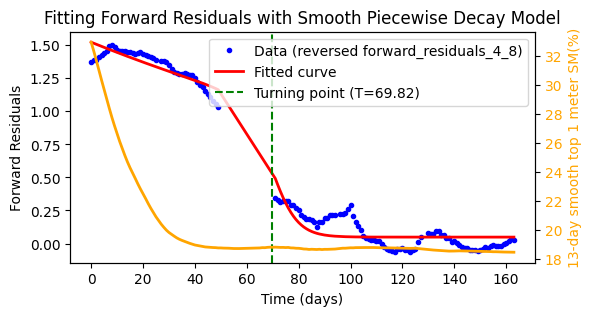

In [ ]:

# 1. Define the smooth_piecewise_decay function
def smooth_piecewise_decay(t, A, k, B, T, width=5):
    # Sigmoid mask for smooth transition
    sigmoid = 1 / (1 + np.exp((t - T) / width))
    decay_part = A * np.exp(k * (t - T)) + B  # Decaying part after the turning point
    flat_part = B  # Flat part after the transition
    return sigmoid * decay_part + (1 - sigmoid) * flat_part  # Piecewise combination

# 2. Prepare the data (t and forward_residuals_4_8)
# Example: Replace these with your actual `t` and `forward_residuals_4_8` data
t0 = dffit['datetime'].iloc[0]
t = (dffit['datetime'] - t0).dt.total_seconds() / (3600 * 24)  # days
reversed_forward_residuals_4_8 = -1* dffit['forward_residuals_4_8'].values  # Replace with your actual data
sm_set5= dffit['13D_sm_set5'].values  # Replace with your actual data

# Mask to exclude 50–70 days (adjust as needed)
mask = ~((t >= 50) & (t <= 70))

# Apply the mask
t_clean = t[mask]
residuals_clean = reversed_forward_residuals_4_8[mask]

# 3. Initial guess for parameters [A, k, B, T]
# These guesses depend on your data range and expected behavior
A0 = np.max(residuals_clean) - np.min(residuals_clean)  # Amplitude difference
k0 = -0.05  # Decay rate, negative because you're expecting a decreasing curve
B0 = np.min(residuals_clean)  # Base value (minimum)
T0 = np.median(t_clean)  # Initial guess for turning point

# 4. Bounds for the parameters to ensure realistic values during fitting
bounds = ([0, -10, -np.inf, 0], [np.inf, 0, np.inf, np.max(t)])

# 5. Fit the model to the data using curve_fit
popt, pcov = curve_fit(smooth_piecewise_decay, t_clean, residuals_clean, 
                       p0=[A0, k0, B0, T0], bounds=bounds)

# 6. Extract optimized parameters
A_opt, k_opt, B_opt, T_opt = popt
print(f"Optimized parameters: A={A_opt:.2f}, k={k_opt:.4f}, B={B_opt:.2f}, T={T_opt:.2f}")

# 7. Generate fitted values
fitted_values = smooth_piecewise_decay(t_clean, *popt)

# 8. Plot the results
plt.figure(figsize=(6,3))
plt.plot(t_clean, residuals_clean, label='Data (reversed forward_residuals_4_8)', color='blue', marker='.', linestyle='None')
plt.plot(t_clean, fitted_values, label='Fitted curve', color='red', linewidth=2)
plt.axvline(T_opt, color='green', linestyle='--', label=f'Turning point (T={T_opt:.2f})')
plt.xlabel('Time (days)')
plt.ylabel('Forward Residuals')
plt.title('Fitting Forward Residuals with Smooth Piecewise Decay Model')
plt.legend(loc='upper right',)
plt.twinx()
plt.plot(t, sm_set5, label='13D_sm_set5 Shape', color='orange', linestyle='-', linewidth=2)
plt.ylabel('13-day smooth top 1 meter SM(%)', color='orange')
plt.tick_params(axis='y', labelcolor='orange')

plt.show()


In [ ]:
stop

NameError: name 'stop' is not defined

Coefficients for dv_2_4Hz model:
13D_smooth_GW303_m: -6.4047
13D_sm_set5: 0.0257

Coefficients for dv_4_8Hz model:
13D_smooth_GW303_m: -6.8237
13D_sm_set5: -0.0927


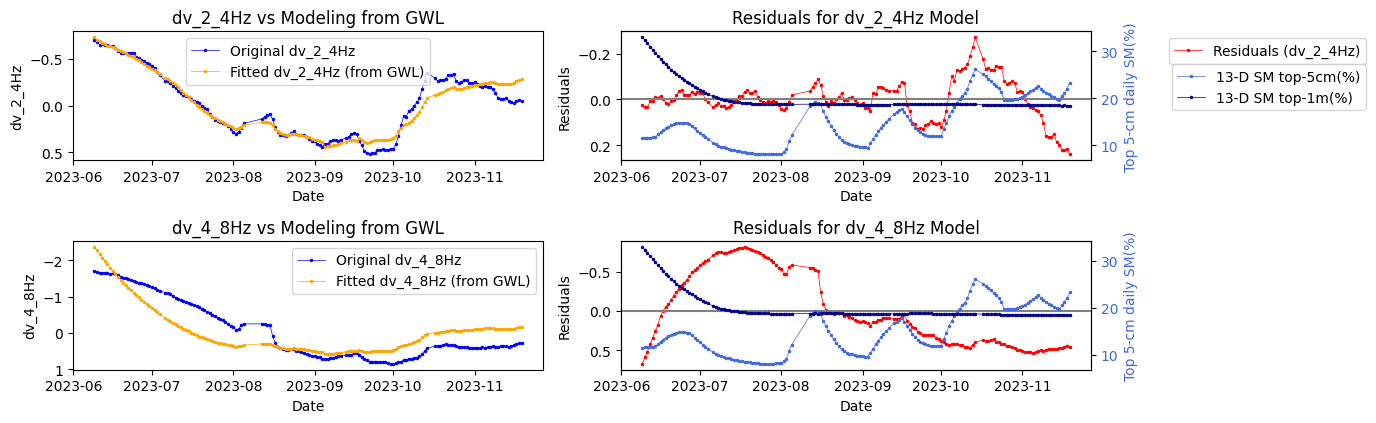

In [ ]:
from sklearn.linear_model import LinearRegression


# Define the predictors (independent variables)
X_multi = df[['13D_smooth_GW303_m', '13D_sm_set5' ]]

# Response variable: dv_2_4Hz
y_2_4 = df['dv_2_4Hz']

# Fit the model for dv_2_4Hz
model_2_4 = LinearRegression()
model_2_4.fit(X_multi, y_2_4)

# Response variable: dv_4_8Hz
y_4_8 = df['dv_4_8Hz']

# Fit the model for dv_4_8Hz
model_4_8 = LinearRegression()
model_4_8.fit(X_multi, y_4_8)

dffit = X_multi.copy()
dffit['dv_2_4Hz'] = y_2_4
dffit['dv_4_8Hz'] = y_4_8

# Predict dv/v using both models
dffit['dv_pred_2_4'] = model_2_4.predict(X_multi)
dffit['dv_pred_4_8'] = model_4_8.predict(X_multi)

# Calculate residuals
dffit['residuals_2_4'] = dffit['dv_2_4Hz'] - dffit['dv_pred_2_4']
dffit['residuals_4_8'] = dffit['dv_4_8Hz'] - dffit['dv_pred_4_8']

# Get the list of predictor names
predictors = X_multi.columns

# Get the coefficients from the model
coeffs_2_4 = model_2_4.coef_
coeffs_4_8 = model_4_8.coef_

# Print the coefficients with corresponding variable names
print("Coefficients for dv_2_4Hz model:")
for name, coef in zip(predictors, coeffs_2_4):
    print(f"{name}: {coef:.4f}")

print("\nCoefficients for dv_4_8Hz model:")
for name, coef in zip(predictors, coeffs_4_8):
    print(f"{name}: {coef:.4f}")


plot_resid(dffit,)
